<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno, Andrea Flores Fernández.

**Fecha:** 24 de noviembre del 2021.

**Expediente** : 722100, 725449.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/diegolazareno/Tarea10_DALopez_AFlores

# Tarea 10: Clase 24

## Enunciado de tarea 

**Realizar la valuación de las opciones barrera para las acciones de Microsoft**, siguiendo los siguientes lineamientos:

1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

### Ejercicio 1

> Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
from datetime import date
import yfinance as yf
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline


# Funciones necesarias
def options_yf(ticker : "Ticker en formato string"):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance. Retorna:
    *calls : un diccionario con los calls a distintas fechas de vencimiento.
    *puts : un diccionario con los puts a distintas fechas de vencimiento.
    
    *ticker : es el símbolo de cotización de la acción
    
    """
    stock = yf.Ticker(ticker)
    calls, puts = {}, {}
    
    def options_yf_(n):
        nonlocal stock
        calls[stock.options[n]] = stock.option_chain(stock.options[n])[0]
        puts[stock.options[n]] = stock.option_chain(stock.options[n])[1]
    
    [options_yf_(n) for n in range(len(stock.options))]
    
    return calls, puts

def returns(closes : "Precios de cierre ajustados de una acción"):
    "returns calcula los rendimientos logarítmicos del precio de una acción"
    
    return np.log(closes / closes.shift(1)).dropna()

def modeloNormal(expiry : "Fecha de expiración del contrato", strike : "Precio de ejercicio",
                     sigma : "Volatilidad", rf : "Tasa libre de riesgo", S0 : "Precio inicial", option : "Call, Put",
                b : "Barrera"):
    """
    modeloNormal elabora la valoración de una opción financiera a través del Modelo de los Rendimientos Normales.
    
    *expiry : es la fecha de expiración del contrato.
    *strike : es el precio de ejercicio del contrato.
    *sigma : es la volatilidad del activo subyacente.
    *rf : es la tasa libre de riesgo (base diaria).
    *S0 : es el precio inicial del activo subyacente.
    *option : es el tipo de opción, Call o Put.
    *b : es la barrera del contrato.
    
    """
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq = 'B')
    ndays = len(dates)
    nscen = 10000
    
    sim_ret = pd.DataFrame(sigma * np.random.randn(ndays, nscen) + rf, index = dates)
    simulations = S0 * np.exp(sim_ret.cumsum())
    simulations.iloc[0, :] = S0
    
    # Valuación del Call
    if option == "Call":
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Barrera' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    # Valuación del Put
    else:
        I = (simulations > b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(strike - simulations, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Barrera' : 
                                np.exp(-rf * ndays) * (I * np.fmax(strike - simulations, 0)).mean(axis = 1)},
                           index = dates)
    
    return opcionEuropea, opcionBarrera, simulations

def histograma(expiry : "Fecha de expiración del contrato", strike : "Precio de ejercicio",
                      returns : "Rendimientos", mu : "Rendimiento esperado", sigma : "Volatilidad", 
                      rf : "Tasa libre de riesgo", S0 : "Precio inicial", option : "Call, Put", b : "Barrera"):
    """
    histograma elabora la valoración de una opción financiera a través del Método del Histograma.
    
    *expiry : es la fecha de expiración del contrato.
    *strike : es el precio de ejercicio del contrato.
    *returns : son los rendimientos logarítmicos de la acción.
    *mu : es el rendimiento esperado del activo subyacente.
    *sigma : es la volatilidad del activo subyacente.
    *rf : es la tasa libre de riesgo (base diaria).
    *S0 : es el precio inicial del activo subyacente.
    *option : es el tipo de opción, Call o Put.
    *b : es la barrera del contrato.
    
    """
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq = 'B')
    ndays = len(dates)
    nscen = 10000
    
    freq, values = np.histogram(returns - mu + rf, bins = 10000)
    prob = freq / np.sum(freq)
    ret = np.random.choice(values[1:], (ndays, nscen), p = prob)
    sim_ret_hist = pd.DataFrame(ret, index = dates)
    simulations = S0 * np.exp(sim_ret_hist.cumsum())
    simulations.iloc[0, :] = S0
    
    # Valuación del Call
    if option == "Call":
        I = (simulations < b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(simulations - strike, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Barrera' : 
                                np.exp(-rf * ndays) * (I * np.fmax(simulations - strike, 0)).mean(axis = 1)},
                           index = dates)
    # Valuación del Put
    else:
        I = (simulations > b).cumsum(axis = 0) == 0
        opcionEuropea = pd.DataFrame({'Prima Europea' : np.exp(-rf * ndays) * np.fmax(strike - simulations, 0).mean(axis = 1)}, 
                           index = dates)
        opcionBarrera = pd.DataFrame({'Prima Barrera' : 
                                np.exp(-rf * ndays) * (I * np.fmax(strike - simulations, 0)).mean(axis = 1)},
                           index = dates)
    
    return opcionEuropea, opcionBarrera, simulations


def confidenceInterval(option : "Primas de la opción", simulations : "Precios simulados", method : "Tipo de opción"):
    """
    confidenceInterval computa un intervalo de confianza para la prima de una opción (europea o barrera).
    
    *options : son las primas de la opción.
    *simulations : son los precios simulados.
    *method : es el tipo de opción.
    
    """
    
    ci = st.norm.interval(0.99, loc = option.iloc[-1].values[0], scale = st.sem(simulations.iloc[-1]))
    results = pd.DataFrame({"Prima" : option.iloc[-1].values[0], "Límite inferior (99% confianza)" : ci[0],
                            "Límite superior (99% confianza)" : ci[1]}, index = [method])
    return results


`Estudiante 1 : Diego`

In [2]:
# Descarga inicial de precios e información de opciones con yfinance
ticker = "MSFT"
start = "2017-11-01"
prices = yf.download(ticker, start = start, end = None, progress = False)["Adj Close"]
calls, puts = options_yf(ticker)
calls.keys()

dict_keys(['2021-12-03', '2021-12-10', '2021-12-17', '2021-12-23', '2021-12-31', '2022-01-21', '2022-02-18', '2022-03-18', '2022-04-14', '2022-06-17', '2022-07-15', '2022-09-16', '2023-01-20', '2023-03-17', '2023-06-16', '2024-01-19'])

Primeramente, se descarga la información de las opciones que se negocian en los mercados de derivados cuyo subyacente es la acción de **Microsoft** (MSFT) con ayuda de la función `options_yf`. Podemos observar que existen varias fechas de expiración para los contratos, incluso hasta el año $2024$. Se decide por valorar las opciones cuya fecha de expiración es el $18$ de febrero del año $2022.$

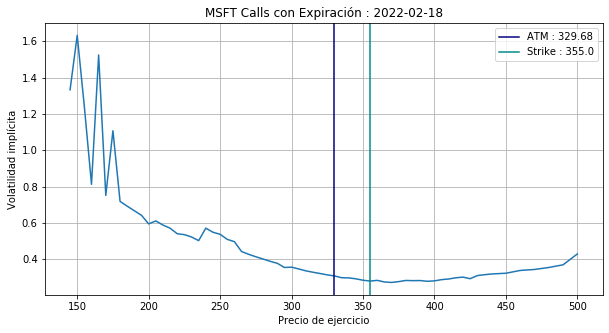

In [3]:
# Fecha de expiración del contrato
fechaExpiracion = "2022-02-18"

# Visualización de la sonrisa de volatilidad
plt.figure(figsize = (10, 5))
plt.title(ticker + " Calls con Expiración : " + fechaExpiracion)
plt.plot(calls[fechaExpiracion]["strike"], calls[fechaExpiracion]["impliedVolatility"])
plt.axvline(prices[-1], color = "navy", label = "ATM : " + str(round(prices[-1], 2)))

idx = calls[fechaExpiracion][(calls[fechaExpiracion]["strike"] > prices[-1]) & 
                             (calls[fechaExpiracion]["strike"] < 360)]["impliedVolatility"].idxmin()
strike = calls[fechaExpiracion].loc[idx, "strike"]
plt.axvline(strike, color = "darkcyan", label = "Strike : " + str(strike))

plt.ylabel("Volatilidad implícita")
plt.xlabel("Precio de ejercicio")
plt.legend(loc = "best")
plt.grid();

Seguido a la descarga de información se grafica la **Sonrisa de Volatilidad** para las opciones del tipo **call** con la fecha de expiración seleccionada. Al trazar el último precio de cotización, de $\$329$, tenemos la representación de una opción que se encuentra `at the money` (pues dicho precio de cotización equivale al precio de ejercicio del contrato) y con esto podemos comprobar que se forma una especie de sonrisa a ambos lados. **Se selecciona una opción del tipo call con precio de ejercicio de $\$355$**, pues dicho contrato es uno de los que tiene menor volatilidad implícita y además está en sintonía con lo que buscamos, pues esperamos que el subyacente suba de valor más allá de este precio pactado para poder ejercer la opción.


## Call Down And Out

+ Call para Microsoft (MSFT)
+ Fecha de Expiración : $2022-02-18$
+ Precio de Ejercicio ($K$) : $\$355$
+ Barrera ($B$) : $\$320$
+ Función de Pago : $max(S_T - K, 0) \space I(B < S_T) = max(S_T - 355, 0) \space I(320 < S_T)$

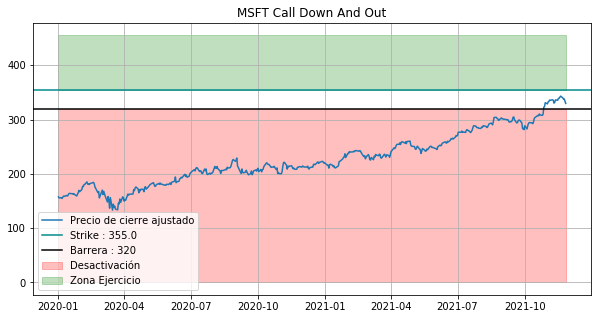

In [4]:
# Barrera
b = 320

# Visualización del Call Down And Out
plt.figure(figsize = (10, 5))
plt.title(ticker + " Call Down And Out")
plt.plot(prices[prices.index > "2020-01-01"], label = "Precio de cierre ajustado")
plt.axhline(strike, color = "darkcyan", label = "Strike : " + str(strike))
plt.axhline(b, color = "k", label = "Barrera : " + str(b))
plt.fill_between(prices[prices.index > "2020-01-01"].index, b, color = "red", alpha = 0.25, label = "Desactivación")
plt.fill_between(prices[prices.index > "2020-01-01"].index, strike, strike + 100, color = "green", 
                 alpha = 0.25, label = "Zona Ejercicio")
plt.legend(loc = "best")
plt.grid();

Como esta es una opción `Call Down And Out` **se decide por poner una barrera en $\$320$**, pues tal cantidad es inferior al último precio de cotización; y **se considera que la acción de Microsoft no la tocará (a la barrera), pues tiene mucho momentum, lo que posiblemente haga que la acción siga a la alza**. Es claro que si el precio de la acción llega a tocar la barrera no se podrá ejercer la opción; mientras que, si supera al precio de ejercicico de $\$355$ sin tocar la barrera, se podrá ejercer el contrato con ganancias.

### Valoración por el Modelo de Rendimientos Normales

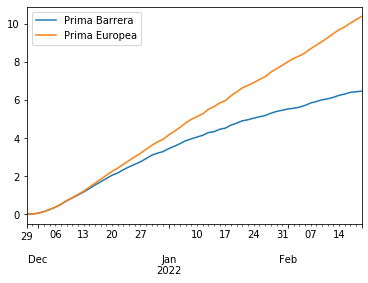

In [5]:
msftReturns = returns(prices)
mu = msftReturns.mean() 
sigma = msftReturns.std()
rf = 0.0024 / 360

callEuropeo, callBarrera, simulations = modeloNormal(fechaExpiracion, strike, sigma, rf, prices[-1], "Call", b)
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [6]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,10.37349,9.134447,11.612533


In [7]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,6.45443,5.215387,7.693473


Por la valuación a través del Modelo de los Rendimientos Normales **verificamos que la prima de la opción barrera es más barata que la prima de una opción equivalente pero del tipo europea**. Además, se computan los intervalos de confianza para cada valoración, por lo que, la prima, con un nivel de confianza del $99\%$, se encontrará entre ambos límites. Podemos decir que la selección de la barrera fue óptima, pues logramos abaratar el precio del contrato.

### Valoración por el Método del Histograma

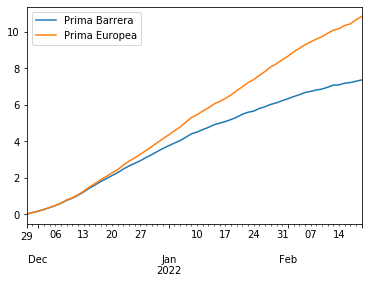

In [8]:
callEuropeo, callBarrera, simulations = histograma(fechaExpiracion, strike, msftReturns, mu, sigma, rf, prices[-1], "Call", b)
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [9]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,10.830437,9.58865,12.072224


In [10]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,7.353241,6.111454,8.595028


Por la valuación a través del Método del Histograma **verificamos que la prima de la opción barrera es más barata que la prima de una opción equivalente pero del tipo europeo**. Además, se computan los intervalos de confianza para cada valoración, por lo que, la prima, con un nivel de confianza del $99\%$, se encontrará entre ambos límites. Podemos decir que la selección de la barrera fue óptima, pues logramos abaratar el precio del contrato.

`Estudiante 2 : Andrea`

In [11]:
# Descarga inicial de precios e información de opciones con yfinance
ticker = "MSFT"
prices = yf.download(ticker, start = "2017-11-01", end = None, progress = False)["Adj Close"]
calls, puts = options_yf(ticker)
calls.keys()

dict_keys(['2021-12-03', '2021-12-10', '2021-12-17', '2021-12-23', '2021-12-31', '2022-01-21', '2022-02-18', '2022-03-18', '2022-04-14', '2022-06-17', '2022-07-15', '2022-09-16', '2023-01-20', '2023-03-17', '2023-06-16', '2024-01-19'])

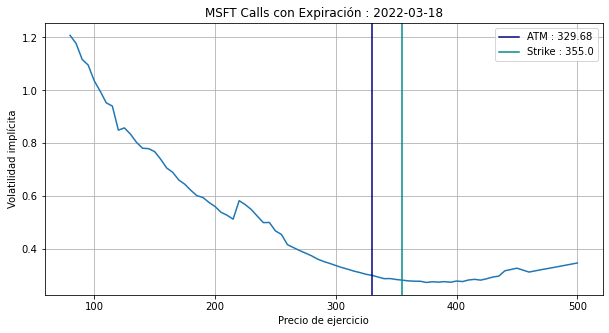

In [12]:
# Fecha de expiración del contrato
fechaExpiracion = "2022-03-18"

# Volatility Smile 
plt.figure(figsize = (10, 5))
plt.title(ticker + " Calls con Expiración : " + fechaExpiracion)
plt.plot(calls[fechaExpiracion]["strike"], calls[fechaExpiracion]["impliedVolatility"])
plt.axvline(prices[-1], color = "navy", label = "ATM : " + str(round(prices[-1], 2)))

idx = calls[fechaExpiracion][(calls[fechaExpiracion]["strike"] > prices[-1]) & 
                             (calls[fechaExpiracion]["strike"] < 360)]["impliedVolatility"].idxmin()
strike = calls[fechaExpiracion].loc[idx, "strike"]
plt.axvline(strike, color = "darkcyan", label = "Strike : " + str(strike))

plt.ylabel("Volatilidad implícita")
plt.xlabel("Precio de ejercicio")
plt.legend(loc = "best")
plt.grid();

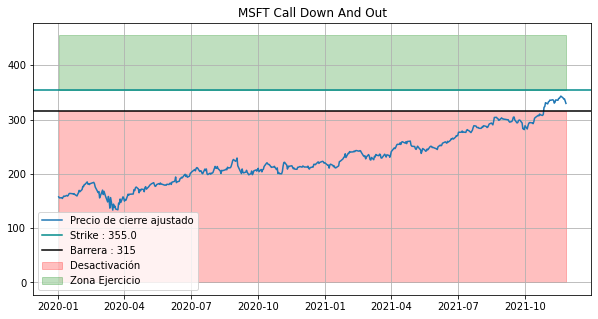

In [13]:
b = 315 # precio barrera inferior al strike price 

# Visualización del Call Down And Out
plt.figure(figsize = (10, 5))
plt.title(ticker + " Call Down And Out")
plt.plot(prices[prices.index > "2020-01-01"], label = "Precio de cierre ajustado")
plt.axhline(strike, color = "darkcyan", label = "Strike : " + str(strike))
plt.axhline(b, color = "k", label = "Barrera : " + str(b))
plt.fill_between(prices[prices.index > "2020-01-01"].index, b, color = "red", alpha = 0.25, label = "Desactivación")
plt.fill_between(prices[prices.index > "2020-01-01"].index, strike, strike + 100, color = "green", 
                 alpha = 0.25, label = "Zona Ejercicio")
plt.legend(loc = "best")
plt.grid();

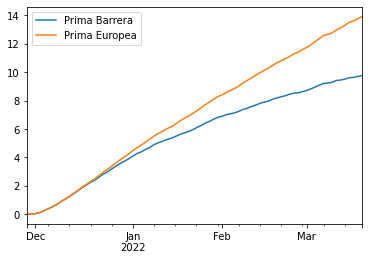

In [14]:
msftReturns = returns(prices)
mu = msftReturns.mean() 
sigma = msftReturns.std()
rf = 0.0024 / 360

callEuropeo, callBarrera, simulations = modeloNormal(fechaExpiracion, strike, sigma, rf, prices[-1], "Call", b)
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [15]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,13.913807,12.482708,15.344905


In [16]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,9.761324,8.330226,11.192423


### Histograma

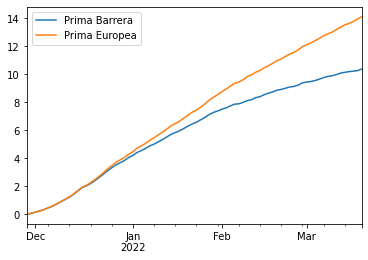

In [17]:
callEuropeo, callBarrera, simulations = histograma(fechaExpiracion, strike, msftReturns, mu, sigma, rf, prices[-1], "Call", b)
ax = callBarrera.plot();
callEuropeo.plot(ax = ax);

In [18]:
confidenceInterval(callEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,14.121302,12.682335,15.560269


In [19]:
confidenceInterval(callBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,10.381815,8.942848,11.820782


La opción Barrera disminuye el precio de la prima 

### Ejercicio 2

> Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

`Estudiante 1 : Diego`

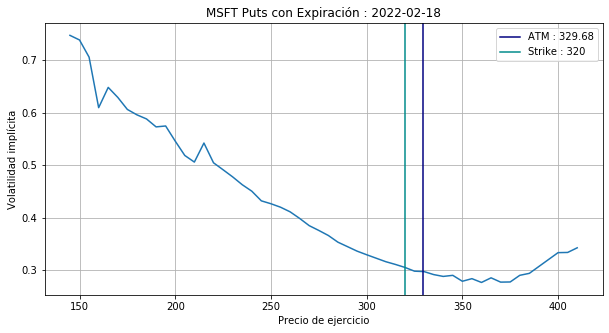

In [11]:
# Visualización de la sonrisa de volatilidad
fechaExpiracion = "2022-02-18"
plt.figure(figsize = (10, 5))
plt.title(ticker + " Puts con Expiración : " + fechaExpiracion)
plt.plot(puts[fechaExpiracion]["strike"], puts[fechaExpiracion]["impliedVolatility"])
plt.axvline(prices[-1], color = "navy", label = "ATM : " + str(round(prices[-1], 2)))

strike = 320
plt.axvline(strike, color = "darkcyan", label = "Strike : " + str(strike))

plt.ylabel("Volatilidad implícita")
plt.xlabel("Precio de ejercicio")
plt.legend(loc = "best")
plt.grid();

Seguido a la descarga de información se grafica la **Sonrisa de Volatilidad** para las opciones del tipo **put** con la fecha de expiración seleccionada. Al trazar el último precio de cotización, de $\$329$, tenemos la representación de una opción que se encuentra `at the money` (pues dicho precio de cotización equivale al precio de ejercicio del contrato) y con esto podemos comprobar que se forma una especie de sonrisa a ambos lados. **Se selecciona una opción del tipo put con precio de ejercicio de $\$320$**, pues dicho contrato está en sintonía con lo que buscamos, pues esperamos que el subyacente baje más allá de dicho precio pactado para poder ejercer la opción.


## Put Up And Out

+ Put para Microsoft (MSFT)
+ Fecha de Expiración : $2022-02-18$
+ Precio de Ejercicio ($K$) : $\$320$
+ Barrera ($B$) : $\$350$
+ Función de Pago : $max(K - S_T, 0) \space I(B > S_T) = max(320 - S_T, 0) \space I(350 > S_T)$

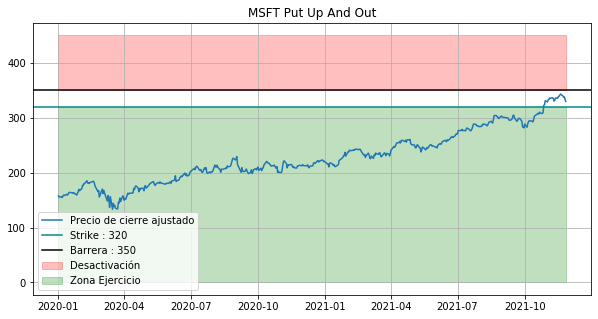

In [12]:
# Barrera
b = 350

# Visualización del Call Down And Out
plt.figure(figsize = (10, 5))
plt.title(ticker + " Put Up And Out")
plt.plot(prices[prices.index > "2020-01-01"], label = "Precio de cierre ajustado")
plt.axhline(strike, color = "darkcyan", label = "Strike : " + str(strike))
plt.axhline(b, color = "k", label = "Barrera : " + str(b))
plt.fill_between(prices[prices.index > "2020-01-01"].index, b, b + 100, color = "red", alpha = 0.25, label = "Desactivación")
plt.fill_between(prices[prices.index > "2020-01-01"].index, strike, color = "green", 
                 alpha = 0.25, label = "Zona Ejercicio")
plt.legend(loc = "best")
plt.grid();

Como esta es una opción `Put Up And Out` **se decide por poner una barrera en $\$350$**, pues tal cantidad es superior al último precio de cotización; y **se considera, desde la perspectiva del análisis fundamental, que la acción de Microsoft no tocará tal barrera, pues, a pesar del momentum, según la inversión en valor y los fundamentales de la compañía se encuentra sobrevalorada, por lo que podría esperarse una fuerte corrección a la baja**. Es claro que si el precio de la acción llega a tocar la barrera no se podrá ejercer la opción; mientras que, si cae por debajo del precio de ejercicico de $\$320$ sin tocar la barrera, se podrá ejercer el contrato con ganancias.

### Valoración por el Modelo de Rendimientos Normales

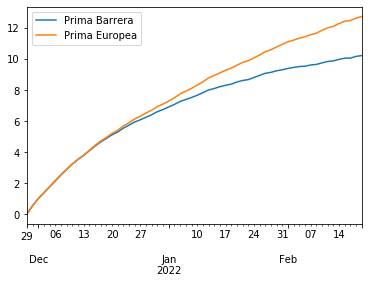

In [13]:
putEuropeo, putBarrera, simulations = modeloNormal(fechaExpiracion, strike, sigma, rf, prices[-1], "Put", b)
ax = putBarrera.plot();
putEuropeo.plot(ax = ax);

In [14]:
confidenceInterval(putEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,12.731497,11.491211,13.971782


In [15]:
confidenceInterval(putBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,10.21174,8.971455,11.452026


Por la valuación a través del Modelo de los Rendimientos Normales **verificamos que la prima de la opción barrera es más barata que la prima de una opción equivalente pero del tipo europea**. Además, se computan los intervalos de confianza para cada valoración, por lo que, la prima, con un nivel de confianza del $99\%$, se encontrará entre ambos límites. Podemos decir que la selección de la barrera fue óptima, pues logramos abaratar el precio del contrato.

### Valoración por el Método del Histograma

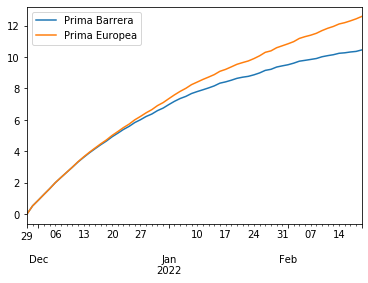

In [16]:
putEuropeo, putBarrera, simulations = histograma(fechaExpiracion, strike, msftReturns, mu, sigma, rf, prices[-1], "Put", b)
ax = putBarrera.plot();
putEuropeo.plot(ax = ax);

In [17]:
confidenceInterval(putEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,12.587349,11.362527,13.812172


In [18]:
confidenceInterval(putBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,10.454526,9.229704,11.679348


Por la valuación a través del Método del Histograma **verificamos que la prima de la opción barrera es más barata que la prima de una opción equivalente pero del tipo europeo**. Además, se computan los intervalos de confianza para cada valoración, por lo que, la prima, con un nivel de confianza del $99\%$, se encontrará entre ambos límites. Podemos decir que la selección de la barrera fue óptima, pues logramos abaratar el precio del contrato.

`Estudiante 2 : Andrea`

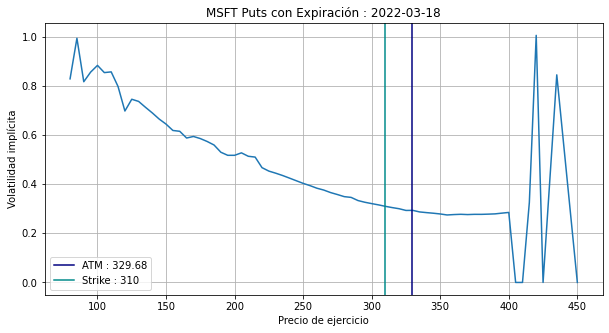

In [28]:
# Volatility Smile
fechaExpiracion = "2022-03-18"
plt.figure(figsize = (10, 5))
plt.title(ticker + " Puts con Expiración : " + fechaExpiracion)
plt.plot(puts[fechaExpiracion]["strike"], puts[fechaExpiracion]["impliedVolatility"])
plt.axvline(prices[-1], color = "navy", label = "ATM : " + str(round(prices[-1], 2)))

strike = 310
plt.axvline(strike, color = "darkcyan", label = "Strike : " + str(strike))

plt.ylabel("Volatilidad implícita")
plt.xlabel("Precio de ejercicio")
plt.legend(loc = "best")
plt.grid();

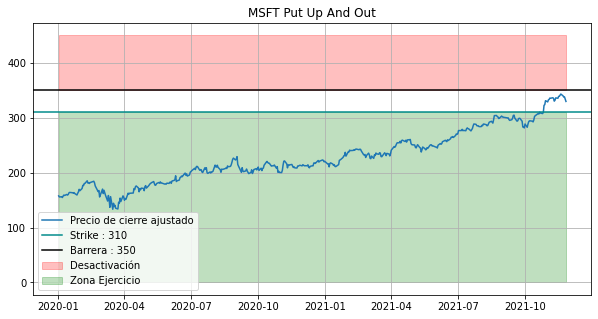

In [29]:
b = 350 # barrera, cantidad superior al último strike price 

# Visualización del Call Down And Out
plt.figure(figsize = (10, 5))
plt.title(ticker + " Put Up And Out")
plt.plot(prices[prices.index > "2020-01-01"], label = "Precio de cierre ajustado")
plt.axhline(strike, color = "darkcyan", label = "Strike : " + str(strike))
plt.axhline(b, color = "k", label = "Barrera : " + str(b))
plt.fill_between(prices[prices.index > "2020-01-01"].index, b, b + 100, color = "red", alpha = 0.25, label = "Desactivación")
plt.fill_between(prices[prices.index > "2020-01-01"].index, strike, color = "green", 
                 alpha = 0.25, label = "Zona Ejercicio")
plt.legend(loc = "best")
plt.grid();

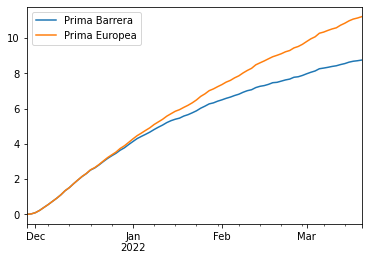

In [30]:
putEuropeo, putBarrera, simulations = modeloNormal(fechaExpiracion, strike, sigma, rf, prices[-1], "Put", b)
ax = putBarrera.plot();
putEuropeo.plot(ax = ax);

In [31]:
confidenceInterval(putEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,11.211228,9.766528,12.655929


In [32]:
confidenceInterval(putBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,8.749531,7.30483,10.194231


### Histograma

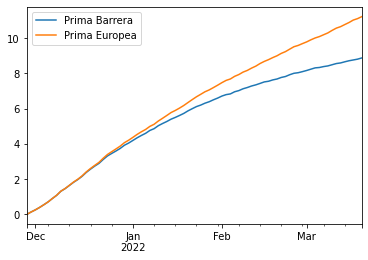

In [33]:
putEuropeo, putBarrera, simulations = histograma(fechaExpiracion, strike, msftReturns, mu, sigma, rf, prices[-1], "Put", b)
ax = putBarrera.plot();
putEuropeo.plot(ax = ax);

In [34]:
confidenceInterval(putEuropeo, simulations, "Opción Europea")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Europea,11.223849,9.782335,12.665364


In [35]:
confidenceInterval(putBarrera, simulations, "Opción Barrera")

,Prima,Límite inferior (99% confianza),Límite superior (99% confianza)
Opción Barrera,8.878311,7.436796,10.319825


#### Conclusión
Nuestro selección barrera fue óptima pues en todos los casos vemos como se nos proporciona una prima con un menor precio. 